# The goal of this notebook is to load generated molecules and pass them through rd_filter, additionally calculating other properties. 

In [5]:
# Is this the right path?

%cd ..

/home/adam/Projects/hybrid-transformer


In [2]:
# Import the necessary libraries

import os
import argparse
import torch
import wandb

from hybrid_transformer.configs.task import TaskConfig
from hybrid_transformer.configs.model import ModelConfig
from hybrid_transformer.configs.trainer import TrainerConfig
from hybrid_transformer.configs.logger import LoggerConfig

from hybrid_transformer.utils.datasets.smiles.auto import AutoDataset
from hybrid_transformer.utils.tokenizers.auto import AutoTokenizer
from hybrid_transformer.models.auto import AutoModel
from hybrid_transformer.utils.loggers.wandb import WandbLogger

from hybrid_transformer.trainers.trainer import Trainer

from hybrid_transformer.utils.objectives.guacamol.objective import GUACAMOL_TASKS
from hybrid_transformer.utils.objectives.molecule_net.objective import MOLECULE_NET_REGRESSION_TASKS
from hybrid_transformer.models.prediction import PREDICTION_MODEL_CONFIGS

%load_ext autoreload
%autoreload 2


/home/adam/miniconda3/envs/hybrid-transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-20 15:37:15.412860: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 15:37:15.474014: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 15:37:15.778829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:37:15.778929: E external/local_xla/xla/stream_executor/cu

In [3]:
# Load the configuration files

# Paths to the configuration files
PATH_TO_TASK_CONFIG = './configs/tasks/guacamol/distribution_learning/config.json'
PATH_TO_MODEL_CONFIG = './configs/models/hybrid_transformer/config.json'
PATH_TO_TRAINER_CONFIG = './configs/trainers/pretrain/config.json'
# PATH_TO_LOGGER_CONFIG = ''

PATH_TO_MODEL_CKPT = './results/pretrain/hybrid_transformer/ckpt.pt'

# Load the configuration files
task_config = TaskConfig.from_pretrained(PATH_TO_TASK_CONFIG)
model_config = ModelConfig.from_pretrained(PATH_TO_MODEL_CONFIG)
trainer_config = TrainerConfig.from_pretrained(PATH_TO_TRAINER_CONFIG)
trainer_config.enable_save_checkpoint = False

# logger_config = LoggerConfig.from_pretrained(PATH_TO_LOGGER_CONFIG)
task_config.validate = False
# logger_config.wandb_log = False

In [4]:
# Auxiliary functions

def save_strings_to_file(strings, filename):
    with open(filename, 'w') as f:
        for s in strings:
            f.write(s + '\n')

def read_strings_from_file(filename):
    with open(filename, 'r') as f:
        strings = f.read().splitlines()
    return strings

def convert_strings_to_lists(strings):
    return [[s, f'MOL{i}'] for i, s in enumerate(strings)]

In [9]:
my_list = read_strings_from_file('generated_molecules.smi')

In [10]:
my_list

['Cc1cc(N2CCOCC2)ccc1N1CC(C)(C)N(CC(N)=O)C1=O',
 'O=C1C(=Cc2ccc(OCCCBr)cc2)COc2ccc(OCCCBr)cc21',
 'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(F)cc1',
 'OC(c1ccccc1)c1cc(Br)c2cccc(C(F)(F)F)c2n1',
 'COC1=NOC(C#CCCCCCC(O)(O)CO)C1',
 'CC(C)C1NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(C(C)C)NCCOc2ccccc2CCCNC1=O',
 'Cc1cc(C)c(C#N)c(O)n1',
 'NC(=O)C1C2C=CC(C2)C1C(=O)NCc1ccccc1',
 'O=C(Nc1ccc(S(=O)(=O)Nc2nccs2)cc1)c1ccccc1',
 'COC(=O)c1ccc([N+](=O)[O-])c(S(=O)(=O)Cc2ccccc2F)c1',
 'CCC(=CC1CCC(C2CC=C3C4CC(O)C5(O)CC(O)CCC5(C)C4CCC32C)CC1)C(C)C',
 'COc1cccc(-c2noc(CN3CCN(c4ccc(F)cc4)CC3)n2)c1OC',
 'Cc1ccc(C(=O)Nc2ccccc2N(C)Cc2ccccc2)cc1C(=O)Nc1ccc(C#N)cc1',
 'O=C(CCCCCCCCCc1ccccc1)NCCCCCCCCc1c[nH]cn1',
 'COc1ccc2[nH]c(=O)c(-c3ccc(N(C)C)cc3)cc2c1',
 'Cc1ccc(-c2nn(-c3cccc(Cl)c3)c3ncnc(N)c23)cc1',
 'COc1c(C(O)C2CCCCC2)ccc2c1-c1n(c(=O)cc3ncccc31)CC2',
 'CC(=NNc1nc(-c2ccc(C)cc2)cs1)c1ccccc1Cl',
 'CCOc1ccc(C=NOCC(=O)Nc2cccc(C(F)(F)F)c2)cc1',
 'CC12NC(Cc3ccc(O)cc31)c1ccccc12',
 'CSc1nnc(C2CC(S)CN2S(=O)(=O)c2ccccc2F)n1C(

In [11]:
validity = sum(tokenizer.is_valid_smiles(generated_molecules)) / len(tokenizer.is_valid_smiles(generated_molecules))
validity

ZeroDivisionError: division by zero

In [12]:
tokenizer.

SyntaxError: invalid syntax (319190680.py, line 1)

In [13]:
import sys
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors, TPSA
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import multiprocessing as mp
from multiprocessing import Pool
import time
import pandas as pd
import os
import json
from docopt import docopt



In [14]:
path_to_alert_collection = './hybrid_transformer/utils/objectives/rd_filter/data/alert_collection.csv'
path_to_rules = './hybrid_transformer/utils/objectives/rd_filter/data/rules.json'
path_to_input_data = './hybrid_transformer/utils/objectives/rd_filter/data/HIV.smi'

num_cores = mp.cpu_count()
rf = RDFilters(path_to_alert_collection)
rule_dict = read_rules(path_to_rules)
p = Pool(num_cores)

In [15]:
# input_data = [x.split() for x in open(path_to_input_data)]
# input_data = [x for x in input_data if len(x) == 2]

input_data = convert_strings_to_lists(read_strings_from_file('generated_molecules.smi'))

rule_list = [x.replace("Rule_", "") for x in rule_dict.keys() if x.startswith("Rule") and rule_dict[x]]
rule_str = " and ".join(rule_list)
rf.build_rule_list(rule_list)
res = list(p.map(rf.evaluate, input_data))
df = pd.DataFrame(res, columns=["SMILES", "NAME", "FILTER", "MW", "LogP", "HBD", "HBA", "TPSA", "Rot"])

In [16]:
df

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,Cc1cc(N2CCOCC2)ccc1N1CC(C)(C)N(CC(N)=O)C1=O,MOL0,OK,346.431,1.33752,1,4,79.11,4
1,O=C1C(=Cc2ccc(OCCCBr)cc2)COc2ccc(OCCCBr)cc21,MOL1,Filter26_alkyl_halide > 0,510.222,5.67290,0,4,44.76,9
2,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(F)cc1,MOL2,OK,341.338,3.41302,1,4,68.53,4
3,OC(c1ccccc1)c1cc(Br)c2cccc(C(F)(F)F)c2n1,MOL3,OK,382.179,5.09780,1,2,33.12,2
4,COC1=NOC(C#CCCCCCC(O)(O)CO)C1,MOL4,OK,271.313,0.36230,3,6,91.51,6
...,...,...,...,...,...,...,...,...,...
76,Cc1cc(C)c(NS(=O)(=O)c2ccc(F)cc2)c(C)c1NS(=O)(=...,MOL76,OK,482.986,5.00596,2,4,92.34,6
77,O=C(CS(=O)(=O)c1cn(CC(=O)N2CCOCC2)c2ccccc12)NC...,MOL77,OK,469.563,1.63270,1,6,97.71,8
78,CC(C#N)c1c(F)cccc1C(F)(F)F,MOL78,OK,217.165,3.47158,0,1,23.79,1
79,O=C(C=Cc1ccc(O)cc1)NCCCCCN1CCC(c2c[nH]c3ccccc2...,MOL79,Filter44_michael_acceptor2 > 0,431.580,5.05280,3,3,68.36,9


In [17]:
df_ok = df[
            (df.FILTER == "OK") &
            df.MW.between(*rule_dict["MW"]) &
            df.LogP.between(*rule_dict["LogP"]) &
            df.HBD.between(*rule_dict["HBD"]) &
            df.HBA.between(*rule_dict["HBA"]) &
            df.TPSA.between(*rule_dict["TPSA"]) &
            df.Rot.between(*rule_dict["Rot"])
            ]

num_input_rows = df.shape[0]
num_output_rows = df_ok.shape[0]
fraction_passed = "%.1f" % (num_output_rows / num_input_rows * 100.0)
print(f"{num_output_rows} of {num_input_rows} passed filters {fraction_passed}%", file=sys.stderr)


38 of 81 passed filters 46.9%


In [18]:
def convert_strings_to_lists(strings):
    return [[s, f'MOL{i}'] for i, s in enumerate(strings)]
    
convert_strings_to_lists(my_list)

[['Cc1cc(N2CCOCC2)ccc1N1CC(C)(C)N(CC(N)=O)C1=O', 'MOL0'],
 ['O=C1C(=Cc2ccc(OCCCBr)cc2)COc2ccc(OCCCBr)cc21', 'MOL1'],
 ['COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(F)cc1', 'MOL2'],
 ['OC(c1ccccc1)c1cc(Br)c2cccc(C(F)(F)F)c2n1', 'MOL3'],
 ['COC1=NOC(C#CCCCCCC(O)(O)CO)C1', 'MOL4'],
 ['CC(C)C1NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(C(C)C)NCCOc2ccccc2CCCNC1=O', 'MOL5'],
 ['Cc1cc(C)c(C#N)c(O)n1', 'MOL6'],
 ['NC(=O)C1C2C=CC(C2)C1C(=O)NCc1ccccc1', 'MOL7'],
 ['O=C(Nc1ccc(S(=O)(=O)Nc2nccs2)cc1)c1ccccc1', 'MOL8'],
 ['COC(=O)c1ccc([N+](=O)[O-])c(S(=O)(=O)Cc2ccccc2F)c1', 'MOL9'],
 ['CCC(=CC1CCC(C2CC=C3C4CC(O)C5(O)CC(O)CCC5(C)C4CCC32C)CC1)C(C)C', 'MOL10'],
 ['COc1cccc(-c2noc(CN3CCN(c4ccc(F)cc4)CC3)n2)c1OC', 'MOL11'],
 ['Cc1ccc(C(=O)Nc2ccccc2N(C)Cc2ccccc2)cc1C(=O)Nc1ccc(C#N)cc1', 'MOL12'],
 ['O=C(CCCCCCCCCc1ccccc1)NCCCCCCCCc1c[nH]cn1', 'MOL13'],
 ['COc1ccc2[nH]c(=O)c(-c3ccc(N(C)C)cc3)cc2c1', 'MOL14'],
 ['Cc1ccc(-c2nn(-c3cccc(Cl)c3)c3ncnc(N)c23)cc1', 'MOL15'],
 ['COc1c(C(O)C2CCCCC2)ccc2c1-c1n(c(=O)cc3ncccc31)CC2', '

In [19]:

    if cmd_input.get("template"):
        template_output_file = cmd_input.get("--out")
        default_rule_template(rf.get_alert_sets(), template_output_file)

    elif cmd_input.get("filter"):
        input_file_name = cmd_input.get("--in")
        rules_file_name = cmd_input.get("--rules") or pkg_resources.resource_filename('rd_filters', "data/rules.json")
        rules_file_path = get_config_file(rules_file_name, "FILTER_RULES_DATA")
        prefix_name = cmd_input.get("--prefix")
        num_cores = cmd_input.get("--np") or mp.cpu_count()
        num_cores = int(num_cores)


        p = Pool(num_cores)
        input_data = [x.split() for x in open(input_file_name)]
        input_data = [x for x in input_data if len(x) == 2]

        rule_list = [x.replace("Rule_", "") for x in rule_dict.keys() if x.startswith("Rule") and rule_dict[x]]
        rule_str = " and ".join(rule_list)
        print(f"Using alerts from {rule_str}", file=sys.stderr)
        rf.build_rule_list(rule_list)
        res = list(p.map(rf.evaluate, input_data))
        df = pd.DataFrame(res, columns=["SMILES", "NAME", "FILTER", "MW", "LogP", "HBD", "HBA", "TPSA", "Rot"])
        df_ok = df[
            (df.FILTER == "OK") &
            df.MW.between(*rule_dict["MW"]) &
            df.LogP.between(*rule_dict["LogP"]) &
            df.HBD.between(*rule_dict["HBD"]) &
            df.HBA.between(*rule_dict["HBA"]) &
            df.TPSA.between(*rule_dict["TPSA"]) &
            df.Rot.between(*rule_dict["Rot"])
            ]
        output_smiles_file = prefix_name + ".smi"
        output_csv_file = prefix_name + ".csv"
        df_ok[["SMILES", "NAME"]].to_csv(f"{output_smiles_file}", sep=" ", index=False, header=False)
        print(f"Wrote SMILES for molecules passing filters to {output_smiles_file}", file=sys.stderr)
        df.to_csv(f"{prefix_name}.csv", index=False)
        print(f"Wrote detailed data to {output_csv_file}", file=sys.stderr)

        num_input_rows = df.shape[0]
        num_output_rows = df_ok.shape[0]
        fraction_passed = "%.1f" % (num_output_rows / num_input_rows * 100.0)
        print(f"{num_output_rows} of {num_input_rows} passed filters {fraction_passed}%", file=sys.stderr)
        elapsed_time = "%.2f" % (time.time() - start_time)
        print(f"Elapsed time {elapsed_time} seconds", file=sys.stderr)

NameError: name 'cmd_input' is not defined

In [24]:
vectors = [df_ok.MW, df_ok.LogP, df_ok.HBD, df_ok.HBA, df_ok.TPSA, df_ok.Rot]

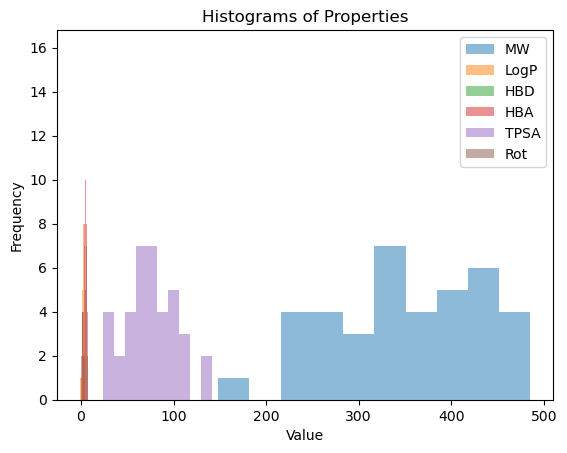

In [25]:
plot_histograms(vectors, ['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'Rot'])

# Filtering

In [27]:
import random
import multiprocessing as mp
import pandas as pd
from multiprocessing import Pool
from hybrid_transformer.utils.objectives.rd_filter.rd_filters import RDFilters, read_rules
from guacamol.utils.chemistry import is_valid
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.Descriptors import ExactMolWt
import numpy as np
from hybrid_transformer.utils.objectives.guacamol.utils import smile_to_QED, smile_to_sa, smile_to_penalized_logP
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def load_data_for_rd_filtering(
        path_to_input_data: str,
        path_to_alert_collection: str = './hybrid_transformer/utils/objectives/rd_filter/data/alert_collection.csv',
        path_to_rules: str = './hybrid_transformer/utils/objectives/rd_filter/data/rules.json',
        seed: int = 1337
):
    random.seed(seed)

    smiles = read_strings_from_file(path_to_input_data)
    if len(smiles) > 10000:
        smiles = random.sample(smiles, 10000)
    
    num_cores = mp.cpu_count()
    rf = RDFilters(path_to_alert_collection)
    rule_dict = read_rules(path_to_rules)
    p = Pool(num_cores)
    
    input_data = convert_strings_to_lists(smiles)
    
    rule_list = [x.replace("Rule_", "") for x in rule_dict.keys() if x.startswith("Rule") and rule_dict[x]]
    rule_str = " and ".join(rule_list)
    rf.build_rule_list(rule_list)
    res = list(p.map(rf.evaluate, input_data))
    df = pd.DataFrame(res, columns=["SMILES", "NAME", "FILTER", "MW", "LogP", "HBD", "HBA", "TPSA", "Rot"])
    df["QED"] = [smile_to_QED(smiles) if is_valid(smiles) else np.nan for smiles in df.SMILES]
    df["SA"] = [smile_to_sa(smiles) if is_valid(smiles) else np.nan for smiles in df.SMILES]
    df["PenalizedLogP"] = [smile_to_penalized_logP(smiles) if is_valid(smiles) else np.nan for smiles in df.SMILES]
    df["Length"] = [len(smiles) for smiles in df.SMILES]
    df_ok = df[
            (df.FILTER == "OK") &
            df.MW.between(*rule_dict["MW"]) &
            df.LogP.between(*rule_dict["LogP"]) &
            df.HBD.between(*rule_dict["HBD"]) &
            df.HBA.between(*rule_dict["HBA"]) &
            df.TPSA.between(*rule_dict["TPSA"]) &
            df.Rot.between(*rule_dict["Rot"])
            ]
    num_input_rows = df.shape[0]
    num_output_rows = df_ok.shape[0]
    fraction_passed = "%.1f" % (num_output_rows / num_input_rows * 100.0)
    print(f"{num_output_rows} of {num_input_rows} passed filters {fraction_passed}%", file=sys.stderr)
    is_valid_smiles = [is_valid(smiles) for smiles in df.SMILES]
    df_valid = df[is_valid_smiles]
    df_summary = df_valid[["MW", "TPSA", "QED", "SA", "PenalizedLogP", "Length"]].describe()
    return df_ok, df, df_summary

# Auxiliary functions

def save_strings_to_file(strings, filename):
    with open(filename, 'w') as f:
        for s in strings:
            f.write(s + '\n')

def read_strings_from_file(filename):
    with open(filename, 'r') as f:
        strings = f.read().splitlines()
    return strings

def convert_strings_to_lists(strings):
    return [[s, f'MOL{i}'] for i, s in enumerate(strings)]


def plot_histograms(vectors, captions, filename = None):
    plt.figure()
    for vector, caption in zip(vectors, captions):
        plt.hist(vector, alpha=0.5, label=caption)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of Properties')
    plt.legend(loc='upper right')
    if filename:
        plt.savefig(filename, format='pdf')
    else:
        plt.show()
    plt.show()
    plt.close()

def plot_kde(vectors, captions, filename = None):
    plt.figure()
    for vector, caption in zip(vectors, captions):
        sns.kdeplot(
   data=vector, x="total_bill", hue="size",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of Properties')
    plt.legend(loc='upper right')
    if filename:
        plt.savefig(filename, format='pdf')
    else:
        plt.show()
    plt.show()
    plt.close()

## Test data

In [18]:

# Load test molecules

PATH_TO_TEST_DATA = './data/guacamol/test/smiles.txt'
df_ok, df_test, df_summary = load_data_for_rd_filtering(PATH_TO_TEST_DATA)


5428 of 10000 passed filters 54.3%


In [19]:
df_summary

,MW,TPSA,QED,SA,PenalizedLogP,Length
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,395.047777,80.127970,0.557059,2.897537,0.453383,47.443200
std,108.088240,37.805594,0.212446,0.814749,4.452282,14.085546
min,102.049000,0.000000,0.022404,1.253505,-95.958394,10.000000
25%,322.336250,55.130000,0.400215,2.330559,-0.008464,38.000000
50%,384.777500,75.630000,0.570837,2.708792,1.170584,46.000000
75%,456.478000,98.425000,0.732043,3.274023,2.071864,56.000000
max,922.786000,396.440000,0.947501,7.987221,6.248091,100.000000


In [50]:
import math

0.78 / math.sqrt(10000)

0.0078000000000000005

In [20]:
# Load test molecules

PATH_TO_JT_DATA = './generated_joint_transformer.smi'
df_ok, df_jf, df_summary = load_data_for_rd_filtering(PATH_TO_JT_DATA)


5329 of 10000 passed filters 53.3%


In [21]:
df_summary

,MW,TPSA,QED,SA,PenalizedLogP,Length
count,9891.000000,9891.000000,9891.000000,9891.000000,9891.000000,9891.000000
mean,399.836055,80.876639,0.553497,2.834507,0.640850,47.940754
std,110.492932,38.035857,0.214702,0.781313,4.030826,14.274095
min,36.461000,0.000000,0.018806,1.200653,-102.493626,2.000000
25%,324.393500,55.840000,0.393230,2.291084,0.146145,38.000000
50%,388.253000,75.710000,0.569862,2.659638,1.251134,46.000000
75%,461.585500,99.240000,0.728435,3.176139,2.147177,56.000000
max,1034.508000,353.900000,0.947682,7.962685,7.536385,117.000000


In [22]:
# Load test molecules

PATH_TO_GPT_DATA = './generated_gpt.smi'
df_ok, df_gpt, df_summary = load_data_for_rd_filtering(PATH_TO_GPT_DATA)


5317 of 10000 passed filters 53.2%


In [23]:
df_summary

,MW,TPSA,QED,SA,PenalizedLogP,Length
count,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000
mean,401.317017,81.373779,0.548675,2.879342,0.547839,48.062368
std,109.485255,38.641512,0.215646,0.798298,4.133064,14.081843
min,88.150000,0.000000,0.016990,1.200653,-85.674748,8.000000
25%,327.775000,55.630000,0.385894,2.326949,0.068278,38.000000
50%,390.556000,75.760000,0.564986,2.695133,1.209264,47.000000
75%,463.544000,99.880000,0.725052,3.243893,2.122374,56.000000
max,1182.319000,352.040000,0.947257,7.987767,10.108286,105.000000


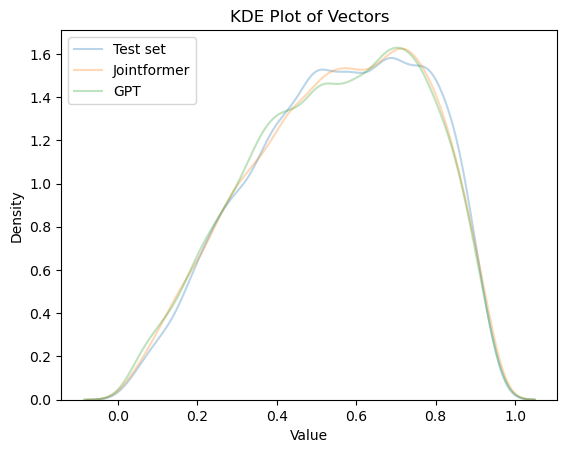

In [40]:
qed = [df_test.QED.values, df_jf.QED.values, df_gpt.QED.values]
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kde(vectors, labels):
    # Create a new figure
    plt.figure()

    # For each vector and corresponding label, plot the KDE
    for vector, label in zip(vectors, labels):
        sns.kdeplot(vector, label=label, fill=False, common_norm=False, palette="crest", alpha=.3, linewidth=1.5)

    # Set labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('KDE Plot of Vectors')
    
    # Include a legend
    plt.legend(loc='upper left')
    
    # Display the plot
    plt.show()
    
plot_kde(qed, ['Test set', 'Jointformer', 'GPT'])

In [1]:
from deepchem.molnet.load_function.zinc15_datasets import load_zinc15
from deepchem.feat import RawFeaturizer

featurizer = RawFeaturizer(smiles=True)
tasks, (train_dataset, val_dataset, test_dataset), transformers = load_zinc15(featurizer=featurizer, splitter='random', size='250K')

/home/adam/miniconda3/envs/hybrid-transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-20 11:47:12.953994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 11:47:13.020836: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 11:47:13.370217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 11:47:13.370309: E external/local_xla/xla/stream_executor/cu

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [6]:
smiles[1][0].X

array(['C#CCCCC(=O)N[C@@H]1CC[C@@H](C)N(CC(=O)NCCCC)C1',
       'Cc1cc(=NC(=O)[C@@H]2C[C@@H](C)O[C@@H](C)C2)[nH]n1CCC#N',
       'CN(Cc1nncn1C)S(=O)(=O)Cc1cccc(C(=O)O)c1', ...,
       'O=C(Nc1cnn(C2CNC2)c1)[C@H]1C[C@@H](O)CN1',
       'COCC(=O)N[C@H]1CCN(C(=O)C(C)C)[C@H](C)C1',
       'Cn1c(=O)nc(O)c2cc(C(=O)NC[C@H](CO)[C@@H]3CCOC3)cnc21'],
      dtype='<U95')